# Анализ результатов работы маркетинга с помощью А/B-теста

## Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

В нашем распоряжении есть таблицы проверяемых гипотез, таблица покупок и таблица посещяемости сайта. Последние две таблицы уже разделены на две группы, так как прошли физическую/тестировочную на людях часть А/В- теста. 
Нам необходимо продолжить/проанализировать результаты А/В- теста и сравнить метрики между двумя группами, после чего мы сможем сделать вывод о влиянии изменений на выручку и порекомендовать сработавшую гипотезу руководителю.

In [1]:
# загрузим все нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mth
pd.options.display.max_colwidth = 130
import matplotlib.patches as mpatches
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## Описание данных

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

### Описание данных df hypothesis

Таблица <b>hypothesis</b> (лог сервера с информацией о посещениях сайта):

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 
Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
# функция для описательной статистики

def describe(df):
    print(df.describe(include=[object]))
    print('------------------------------------------------')
    print(df.describe(include=[int]).applymap("{:.0f}".format))

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
describe(hypothesis)

                                                                                      Hypothesis
count                                                                                          9
unique                                                                                         9
top     Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
freq                                                                                           1
------------------------------------------------
      Reach Impact Confidence Efforts
count     9      9          9       9
mean      5      5          6       5
std       3      3          3       3
min       1      1          1       1
25%       3      3          3       3
50%       3      3          7       5
75%       8      7          8       6
max      10     10          9      10


<font color='orange'><b>*Наблюдение_1*</b></font>

- всего теорий 9 шт
- пропущенных значений нет
- никакая гипотеза в df не давала уверенность на 10 баллов

### Описание данных df orders 

Таблица <b>orders</b> (лог сервера с информацией о посещениях сайта):

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [7]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
describe(orders)

              date group
count         1197  1197
unique          31     2
top     2019-08-05     B
freq            48   640
------------------------------------------------
      transactionId   visitorId  revenue
count          1197        1197     1197
mean     2155621386  2165960143     8348
std      1229084905  1236014192    39191
min         1062393     5114589       50
25%      1166775572  1111826046     1220
50%      2145193898  2217984702     2978
75%      3237740112  3177606451     8290
max      4293855558  4283872382  1294500


<font color='orange'><b>*Наблюдение_2*</b></font>

- всего заказов сделали - 1197
- пустых значений нет
- столбец date нужно перевести в формат datetime
- чаще покупки совершали пользователи из группы В
- чаще всего люди закупались в начале августа
- между средней выручкой и медианной разница почти в три раза + стандартное отклонение тоже достаточно большое, что говорит о влиянии аномальных значений

### Описание данных df visits

Таблица <b>visitors</b> (лог сервера с информацией о посещениях сайта):

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [10]:
visits.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
describe(visits)

              date group
count           62    62
unique          31     2
top     2019-08-13     A
freq             2    31
------------------------------------------------
      visitors
count       62
mean       607
std        114
min        361
25%        534
50%        624
75%        710
max        770


<font color='orange'><b>*Наблюдение_3*</b></font>

- количество строк - 62
- пустых значений нет
- даты одинаково разбиты на две группы (одна дата для А = дата для В)
- группа А и В имеют равное количество дней (31)
- столбец date нужно перевести в формат datetime
- мин количество людей в день -  361 человек, макс - 770 человек
- для анализа взят август месяц 2019 года (31 день)

### Вывод

Мы первично изучили datafremes, подготовим их к анализу

## Подготовка данных

In [13]:
# переведем имена столбцов в змеиный регистр

hypothesis.columns = hypothesis.columns.str.lower()

In [14]:
# переименуем столбцы

orders = orders.rename(columns={'transactionId': 'order_id', 
                          'visitorId': 'user_id'})

In [15]:
# проверим данные на явные дубликаты

print(f'Количество дубликатов hypothesis {hypothesis.duplicated().sum()}')
print(f'Количество дубликатов orders {orders.duplicated().sum()}')
print(f'Количество дубликатов costs {visits.duplicated().sum()}')

Количество дубликатов hypothesis 0
Количество дубликатов orders 0
Количество дубликатов costs 0


In [16]:
# приводим данные времени к формату datetime

orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')
visits['date'] = pd.to_datetime(visits['date'], format = '%Y-%m-%d')

In [17]:
# проверим даты в df-мах

print(f"Интервал дат в df orders: {orders['date'].dt.date.min()} / {orders['date'].dt.date.max()}")
print(f"Интервал дат в df visits: {visits['date'].dt.date.min()} / {visits['date'].dt.date.max()}")

Интервал дат в df orders: 2019-08-01 / 2019-08-31
Интервал дат в df visits: 2019-08-01 / 2019-08-31


### Вывод

Мы подготовили данные к анализу. Можем приступать.

## Приоритизация гипотез.

В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

### Фреймворк ICE для приоритизации гипотез. 
Отсортируйте их по убыванию приоритета.

In [18]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False).style.format({'ICE': '{:.1f}'})

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


<font color='orange'><b>*Наблюдение_4*</b></font>

- первая тройка гипотез на проверку по ICE (impact, confidence, effort / «влияние, уверенность, усилия») - 8, 0, 7

### Фреймворк RICE для приоритизации гипотез. 
Отсортируйте их по убыванию приоритета.

In [19]:
hypothesis['RICE'] = hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach'] / hypothesis['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False).style.format({'RICE': '{:.1f}'})

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<font color='orange'><b>*Наблюдение_5*</b></font>

- первая тройка гипотез на проверку по RICE ( reach, impact, confidence, effort / «охват, влияние, уверенность, усилия») - 7, 2

### Как изменилась приоритизация гипотез при применении RICE вместо ICE. 
Объясните, почему так произошло.

In [20]:
numeric_columns = hypothesis.drop(columns=['hypothesis']).columns

hypothesis.style.format({'ICE': '{:.1f}', 'RICE': '{:.1f}'}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2


In [21]:
numeric_columns

Index(['reach', 'impact', 'confidence', 'efforts', 'ICE', 'RICE'], dtype='object')

### Вывод

Мы видим, как на приоритет повлиял параметр охвата пользователей в RICE. Мы видим, что первая по приоритетам в ICE 8-ая гипотеза в RICE теперь даже не в первой тройке. А вот 4-ая гипотеза и там и там последняя.

Я бы предложила рассматривать только гипотезы 7 и 2.

## A/А-тест
Перед тем как проводить анализ А/В-теста, мне кажется логично проверить правильность данных, так как не я составляла данные и не могу отвечать за их правилность/чистоту. Ну и плюс дабл чек никогда не бывает лишним.

Критерии успешности А/А теста:
- Количество пользователей в различных группах различается не более, чем на 0.5%
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста

Поэтому попробуем следующее:
- Проверим выборки на равность долей (за ключевую метрику возьмем конверсию (ибо у меня больше идей нет, по какому параметру это проверить))
- Проверим, что выборки взяты из нормальной ген. совокупности *
- Проверим как различается выборки в двух группах *
- Рассчитаем минимальный необходимый размер выборки (http://www.evanmiller.org/ab-testing/sample-size.html) 
- Определим оптимальную длительность A/B-теста (https://vwo.com/tools/ab-test-duration-calculator/)
- Проверим, есть ли одни и теже пользователи в разных группах

'*' Если я все верно понимаю, то все что зависело конкретно от аналитика для теста - собрать нужное количество людей для анализа и уже после провести анализ результатов. Соответсвенно, мы должны проверять распределение только посетителей.

### Проверка гипотезы о равенстве долей
С помощью этого анализа можем сделать предварительный вывод о том, сработала ли проверяеммая гипотеза.

H0 - статистически значимых различий в конверсии между группами нет  
H1 - есть статистически значимые различия в конверсии между группами  
уровень значимости - 5% ( по хорошему, согласно выше написанному надо чтобы значение было 1%, но из-за возможных выбросов (а мы видели, что они есть по описательной статистике df orders) расширим границы)  
применим метод стандартных отклонений стандартного нормального распределения

In [21]:
alpha = .05 # критический уровень статистической значимости

# конверсия в первой группе:
p1 = orders[orders['group']=='A']['user_id'].count()/visits[visits['group']=='A']['visitors'].sum()

# конверсия во второй группе:
p2 = orders[orders['group']=='B']['user_id'].count()/visits[visits['group']=='B']['visitors'].sum()

# пропорция конверсии в комбинированном датасете:
p_combined = (orders[orders['group']=='A']['user_id'].count() 
              + orders[orders['group']=='B']['user_id'].count()) /(visits[visits['group']=='A']['visitors'].sum() 
                                                                   + visits[visits['group']=='B']['visitors'].sum())

# разница конверсий в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visits[visits['group']=='A']['visitors'].sum() 
                                                                 + 1/visits[visits['group']=='B']['visitors'].sum()))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

p-значение:  0.02320723394441848
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [22]:
print(f'Начальная конверсия: {p1.round(4) * 100}%')
print(f'Новая конверсия: {p2.round(4) * 100}%')
print(f'Относительное изменение конверсии: {(abs((p2-p1)/p1).round(4))* 100}%')

Начальная конверсия: 2.97%
Новая конверсия: 3.38%
Относительное изменение конверсии: 13.81%


<font color='orange'><b>*Наблюдение_6*</b></font>

- выходит, мы уже сейчас можем сказать, что проверяемая гипотеза сработала (при уровне значимости 5%).

### Проверка ген. совокупности на нормальность

H0 - распределение нормально  
H1 - распределение не нормально  
уровень значимости - 5%  
применим критерий Шапиро-Уилка

In [23]:
sample_1 = visits['visitors']

alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(sample_1)
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.002020221436396241
Отвергаем нулевую гипотезу: распределение не нормально


<font color='orange'><b>*Наблюдение_7*</b></font>

- ген. совокумность не нормальна, так как подвержана выбросам.

### Распределение пользователей по группам
Так как ген. совокупность распределена не нормально, буду использовать непараметрический тест Уилкоксона-Манна-Уитни для оценки значимости разности распределений.

H0 - распределения равны  
H1 - распределение не равны  
уровень значимости - 0.5% (согласно критериям успешности А/А-теста)  
применим статистический критерий Манна-Уитни

In [24]:
sample_1 = visits[visits['group']=='A']['visitors']
sample_2 = visits[visits['group']=='B']['visitors']

alpha = 0.005  # критический уровень статистической значимости

results = st.mannwhitneyu(sample_1, sample_2)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-значение:  0.7301376549390499
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [25]:
print(f'Количество людей в гр.А: {sample_1.sum()}')
print(f'Количество людей в гр.В: {sample_2.sum()}')
print(f'Всего людей: {sample_2.sum() + sample_2.sum()}')

Количество людей в гр.А: 18736
Количество людей в гр.В: 18916
Всего людей: 37832


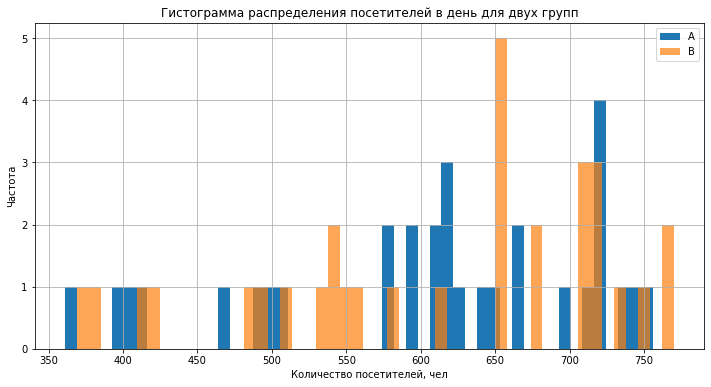

In [26]:
# визуализируем распределение

ax = sample_1.plot(kind = 'hist', bins = 50, grid=True, rot=0, label='A')
sample_2.plot(kind = 'hist', bins = 50, figsize = (12,6), grid=True, rot=0, ax=ax, alpha=0.7, label='B')
plt.legend()
plt.title("Гистограмма распределения посетителей в день для двух групп")
plt.xlabel("Количество посетителей, чел")
plt.ylabel("Частота")
plt.show()

<font color='orange'><b>*Наблюдение_8*</b></font>

- распределения похожи на бета-распределение
- различия количества поситителей в группе А и В стат. не значимы

### Минимальный необходимый размер выборки
http://www.evanmiller.org/ab-testing/sample-size.html

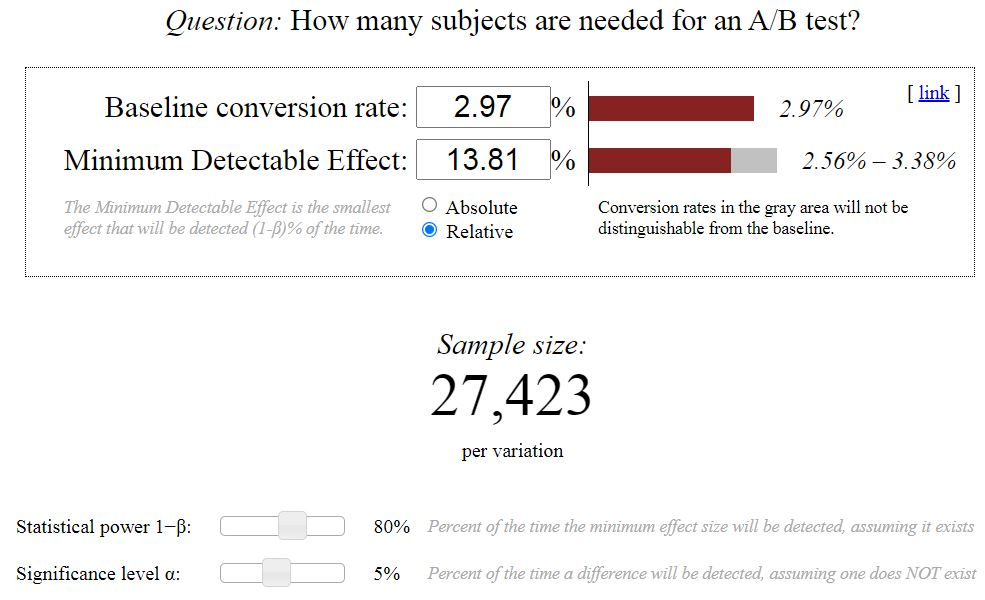

<font color='orange'><b>*Наблюдение_9*</b></font>

- в тесте участвуют 37832 человек, что прекрасно перекрыавает мин количество в 27423 человека.

### Оптимальна длительность A/B-теста
https://vwo.com/tools/ab-test-duration-calculator/

In [27]:
visits['visitors'].median()

624.5

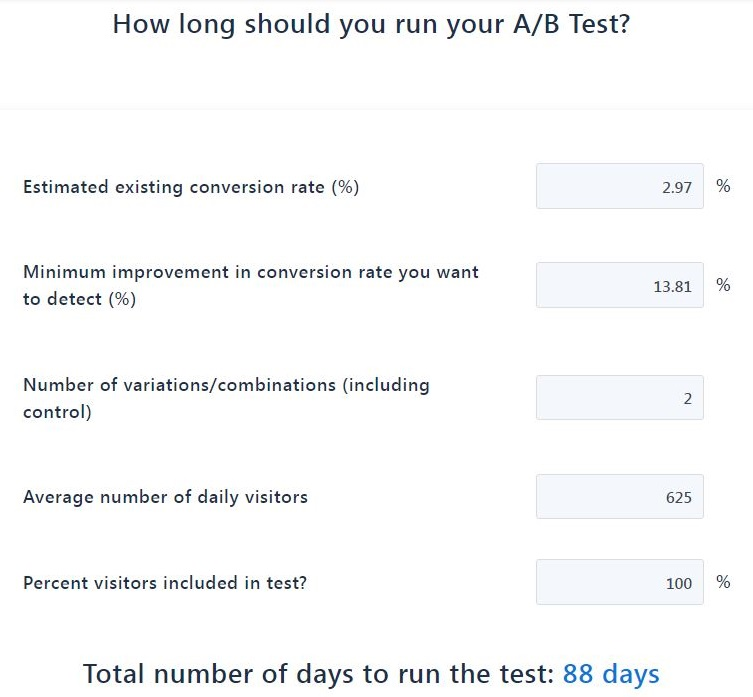

<font color='orange'><b>*Наблюдение_10*</b></font>

- тест был проведен всего за месяц, а по калькулятору необходимо минумим почти 3. 

Возможно, тест был остановлен, так как решили сделать промежуточную проверку по каким-то своим соображениям. Ну или я посчитала неверно)

### Проверка пользователей на принадлежность к одним группам

In [28]:
# разделим df на два по группам

orders_B = orders[['user_id', 'group', 'revenue']].query('group == "B"')
orders_A = orders[['user_id', 'group', 'revenue']].query('group == "A"')

In [29]:
# создадим df c пользователями, которые есть и в А и в В

bad_orders = orders_A.merge(orders_B, on='user_id', how='inner')

In [30]:
# создадим df без "двоиных" пользователей

bad_users_list = bad_orders['user_id'].unique()
orders_clean = orders.loc[~orders['user_id'].isin(bad_users_list)]

In [31]:
bad_orders['user_id'].nunique()

58

In [32]:
# check

if bad_orders['user_id'].nunique() == orders['user_id'].nunique() - orders_clean['user_id'].nunique():
    print('ВСЕ ОК')

ВСЕ ОК


In [33]:
# посмотрим, какую долю выручки составляют 'двойные' пользователи

bad_revenue = bad_orders.groupby('user_id')[['revenue_x', 'revenue_y']].agg(['sum']).reset_index()
bad_revenue.columns = ['user_id', 'revenue_A', 'revenue_B']
bad_revenue.sample(3)

,user_id,revenue_A,revenue_B
0,8300375,1790,10510
41,3234906277,7555,7555
17,1602967004,4040,4740


In [34]:
print(f" Доля суммы от 'двойных' плательщиков в гр.А: ")
print(f" {(bad_revenue['revenue_A'].sum()/orders_A['revenue'].sum()).round(4)*100}%")
print('------------------------------------------------')
print(f" Доля суммы от 'двойных' плательщиков в гр. B: ")
print(f" {(bad_revenue['revenue_B'].sum()/orders_B['revenue'].sum()).round(4)*100}%")

 Доля суммы от 'двойных' плательщиков в гр.А: 
 35.11%
------------------------------------------------
 Доля суммы от 'двойных' плательщиков в гр. B: 
 35.39%


<font color='orange'><b>*Наблюдение_11*</b></font>

- есть 58 пользователей (почти 6% всех пользователей (58/1031)), которые попали в обе группы. Цифра незначительная, но они возможно могут повлиять на анализ, что создаст у нас ложную картину выводов
- в обоих группах доля их влияния на общую выручку ~ 35%, что достаточно много!
- возможно удаление этих данных повлияет на результат и стат. значимость параметров в будущем, поэтому будем сравнивать выборки с этими юзерами и без них позже

P.S. в такой ситуации, наверное, стоит прекратить A/B-тест и обратиться к людям, которые его проводили для переписания алгоритма теста.

### Вывод

- Мы проверили адекватность проведения A/B теста с помощью методов А/А теста: в общем данные собраны корректно
- Одно но: есть пользователи, которые учавствовали в двух группах, что протеворечит принципам А/В-теста
- Уже на этом этапе можем говорить о том, что гипотеза В сработала  

## Анализ A/B-теста
Вы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

In [35]:
# два df для анализа + один очищенный

print(orders_clean.sample(3))
print('------------------')
print(orders.sample(3))
print('------------------')
print(visits.sample(3))

        order_id     user_id       date  revenue group
268   3897826085  3927376365 2019-08-18    10450     B
1117  3003595335  1810540789 2019-08-13    11565     B
266   2012012971  1516351054 2019-08-18    14400     B
------------------
       order_id     user_id       date  revenue group
528  1543948528   492739583 2019-08-19      750     A
279  1101659272  1648269707 2019-08-18      860     A
908  3352225027  1807547430 2019-08-05       75     B
------------------
         date group  visitors
11 2019-08-12     A       595
61 2019-08-31     B       718
22 2019-08-23     A       468


### График кумулятивной выручки по группам. 
Сделайте выводы и предположения.

In [36]:
# Посмотрим, сколько в среднем (используем медиану, чтобы сгладить выбросы) в день приносит каждая группа

orders.groupby(['date','group'])['revenue'].sum().groupby('group').median()

group
A    112473
B    147274
Name: revenue, dtype: int64

In [37]:
def plot_camulat_rev(df):
    # создаем массив уникальных пар значений дат и групп теста
    datesGroups = df[['date','group']].drop_duplicates() 

    # получаем агрегированные кумулятивные по дням данные о заказах 
    ordersAggregated = datesGroups.apply(lambda x: df[np.logical_and(df['date'] <= x['date'], df['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

    # получаем агрегированные кумулятивные по дням данные о посетителях 
    visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], 
                                                                           visits['group'] == x['group'])] \
                                           .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
                                            .sort_values(by=['date','group'])

    # объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
    cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
    cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
    
    # датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
    cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

    # датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
    cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
    
    plt.figure(figsize=(14,6))
    ax = sns.lineplot(x=cumulativeRevenueA['date'], y=cumulativeRevenueA['revenue'], label='A')
    ax = sns.lineplot(x=cumulativeRevenueB['date'], y=cumulativeRevenueB['revenue'], label='B')
    plt.grid()
    plt.title('Сравнение динамик кумулятивной выручки группы А и В', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_ylabel('Выручка, млн руб', fontsize=12)
    plt.show() 
    
    return

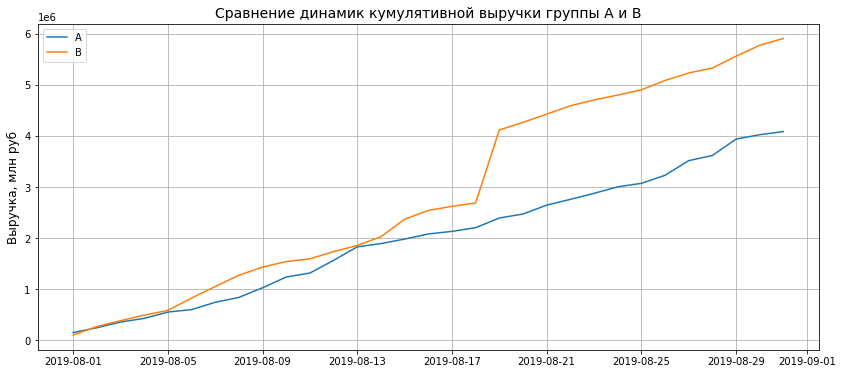

In [38]:
plot_camulat_rev(orders)

<font color='orange'><b>*Наблюдение_12*</b></font>

- Мы наблюдаем почти линейный (= равномерный) рост в течении всего месяца, за исключением резкого всплеска в группе В от 19.08. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 
- Группа В стабильно выше показывает уровень выручки, несмотря на резкий всплеск.

Глянем что там было в районе 19 августа в группе B

In [39]:
# проверим количество заказов

orders.query("'2019-08-16' <= date <= '2019-08-22' and group == 'B'").groupby('date')['order_id'].agg(['count']).reset_index()

,date,count
0,2019-08-16,20
1,2019-08-17,14
2,2019-08-18,9
3,2019-08-19,21
4,2019-08-20,20
5,2019-08-21,14
6,2019-08-22,25


In [40]:
# медиана по количеству заказов в день для группы В

orders.query("group == 'B'").groupby('date')['order_id'].count().median()

21.0

In [41]:
# проверим стоимость заказов 2019-08-19

orders.query("date == '2019-08-19' and group == 'B'")['revenue'].sort_values(ascending=False).head(3)

425    1294500
527      33405
461      26550
Name: revenue, dtype: int64

In [42]:
# вся выручка за 2019-08-19 гр В

orders.query("date == '2019-08-19' and group == 'B'")['revenue'].sum()

1429920

<font color='orange'><b>*Наблюдение_13*</b></font>

- По количеству заказов аномалий нет (медианное значение по всей выборке для гр.В 21 заказ в день, что как раз соотвествует значению заказов 19 августа), а вот по стоимости есть один очень дорогой- 1,294,500. Это 90.5% (1294500/1429920) общей выручки в группе В за этот день.
- наверное в будущем, это значение попадет в выброс

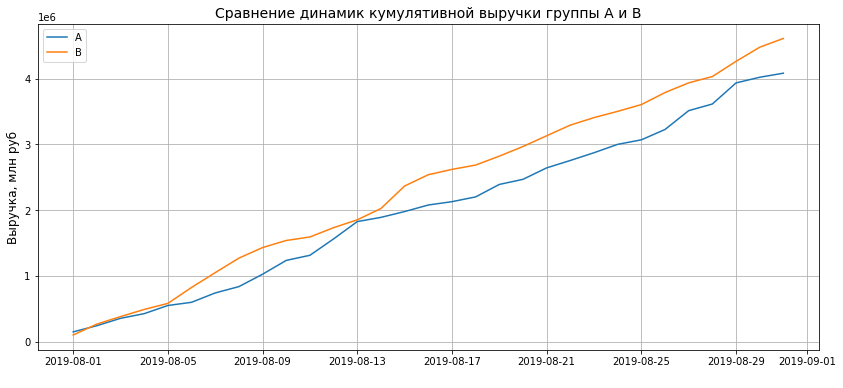

In [43]:
# перестроим график без этого выброса

plot_camulat_rev(orders.query("revenue != 1294500"))

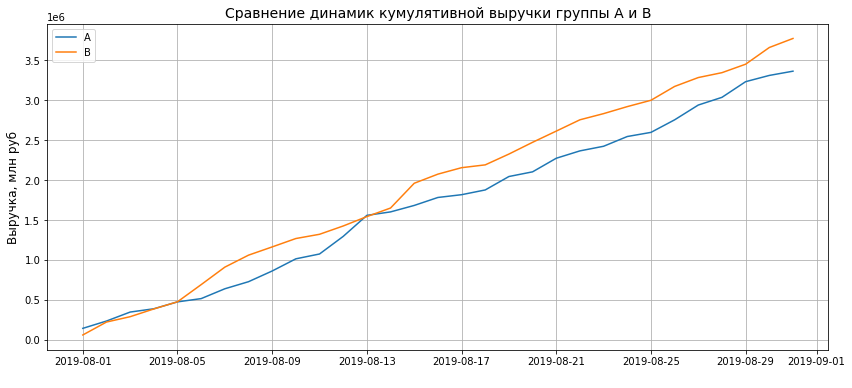

In [44]:
# перестроим график без выброса и пересекающихся пользователей

plot_camulat_rev(orders_clean.query("revenue != 1294500"))

<font color='orange'><b>*Наблюдение_14*</b></font>

- Теперь прямые выглядят адекватно и удаление данного выброса не повлияло на выводы о выручке по визуализации: группа В получает выручку больше чем гр.А
- так же мы вывели таблицу без пересекающихся пользователей и видим, что вид графика остался прежним, но изменилась ось y -  выручки стало меньше и она стала не так быстро расти, что лигично, так как мы исключили пользователей с покупками.

### График кумулятивного среднего чека по группам. 
Сделайте выводы и предположения.

In [45]:
def plot_camulat_mean(df):
    # создаем массив уникальных пар значений дат и групп теста
    datesGroups = df[['date','group']].drop_duplicates() 

    # получаем агрегированные кумулятивные по дням данные о заказах 
    ordersAggregated = datesGroups.apply(lambda x: df[np.logical_and(df['date'] <= x['date'], df['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

    # получаем агрегированные кумулятивные по дням данные о посетителях 
    visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], 
                                                                           visits['group'] == x['group'])] \
                                           .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
                                            .sort_values(by=['date','group'])

    # объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
    cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
    cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
    
    # датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
    cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

    # датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
    cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
    
    plt.figure(figsize=(14,6))
    ax = sns.lineplot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
    ax = sns.lineplot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
    plt.legend() 
    plt.grid()
    plt.title('Сравнение динамик кумулятивного среднего чека группы А и В', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_ylabel('Средний чек, руб', fontsize=12)
    plt.show()
    
    return

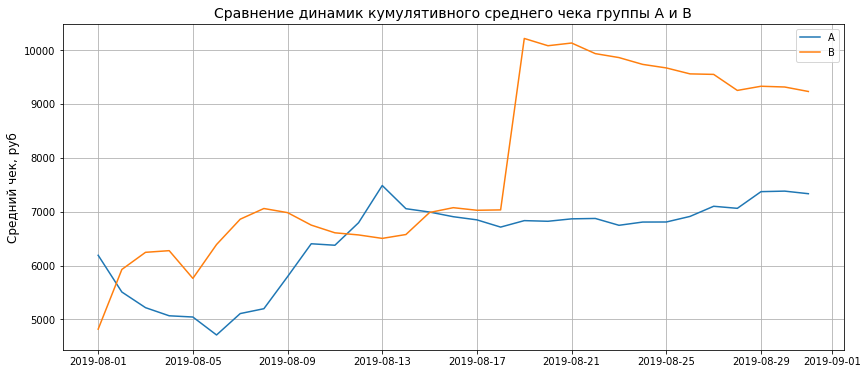

In [46]:
plot_camulat_mean(orders)

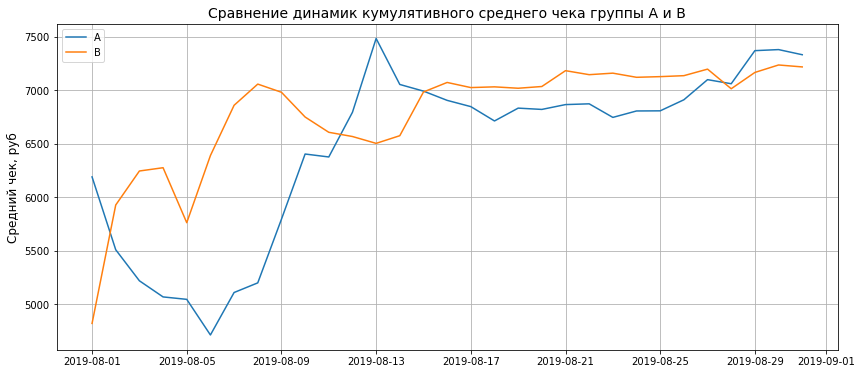

In [47]:
# без выброса

plot_camulat_mean(orders.query("revenue != 1294500"))

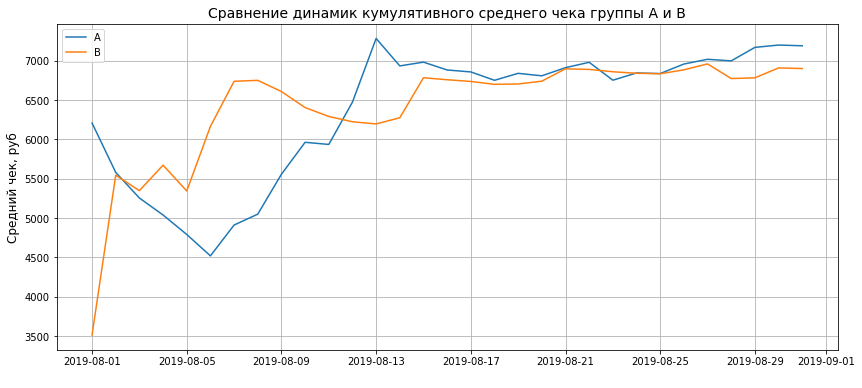

In [48]:
# перестроим график без выброса и пересекающихся пользователей

plot_camulat_mean(orders_clean.query("revenue != 1294500"))

<font color='orange'><b>*Наблюдение_15*</b></font>

- средний чек на первом графике повторяет аномалии графика кум. выручки
- сред. чек гр. В больше чем гр. А до 15 числа, далее они на одном уровне за исключением последних нескольких дней месяца - ср. чек гр. А растет
- средний чек становится более равномерным после первой половины месяца, а для группы А даже начинает расти к концу месяца
- так как после удаления аномалии мы видели вполне равномерный рост выручки, а сейчас на "чистых" графиках мы опять видим относительно резкие всплески и падения, то можно предположить, что они связаны с аномалиями в количестве заказов
- выглядит, как будто крупные заказы доминировали в начале месяца для гр.В
- самый последний график так же имеет резкие скачки, но график стал чуть более плавным, хотя удаленные пользователи не повлияли на общую тенденцию.

Так как аномалий возможно слишком много, а не одна, то проще будет посмотреть по гистограмам и перцентилям выпадающие точки, что сделаем чуть позже

### График относительного изменения кумулятивного среднего чека группы B к группе A. 
Сделайте выводы и предположения.

In [49]:
def plot_camulat_mean_B(df):
    
    # создаем массив уникальных пар значений дат и групп теста
    datesGroups = df[['date','group']].drop_duplicates() 

    # получаем агрегированные кумулятивные по дням данные о заказах 
    ordersAggregated = datesGroups.apply(lambda x: df[np.logical_and(df['date'] <= x['date'], df['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

    # получаем агрегированные кумулятивные по дням данные о посетителях 
    visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], 
                                                                           visits['group'] == x['group'])] \
                                           .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
                                            .sort_values(by=['date','group'])

    # объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
    cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
    cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
    
    # датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
    cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

    # датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
    cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
    
    # собираем данные в одном датафрейме
    mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', 
                                                       suffixes=['A', 'B'])
    
    # cтроим отношение средних чеков
    plt.figure(figsize=(14,6))
    plt.plot(mergedCumulativeRevenue['date'], 
             (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
             (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
    
    # добавляем ось X
    plt.axhline(y=0, color='black', linestyle='--')                   
    plt.grid()
    plt.title('Динамика относительного различия кумулятивного среднего чека групп B к А', fontsize=14)
    plt.ylabel('Безразмерная величина', fontsize=12)
    plt.show()
    
    return

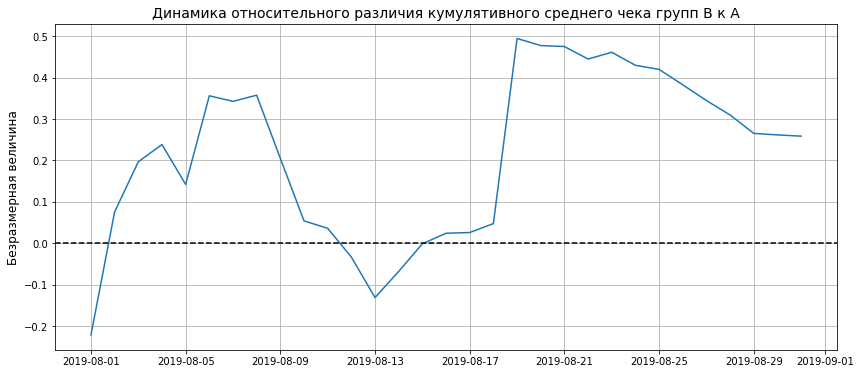

In [50]:
plot_camulat_mean_B(orders)

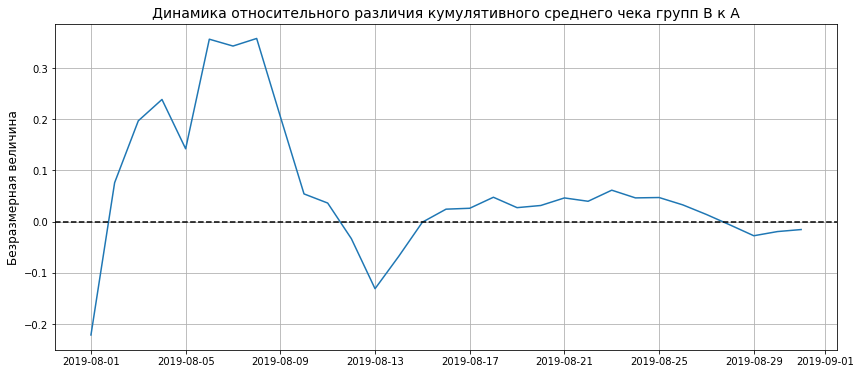

In [51]:
# без выброса

plot_camulat_mean_B(orders.query("revenue != 1294500"))

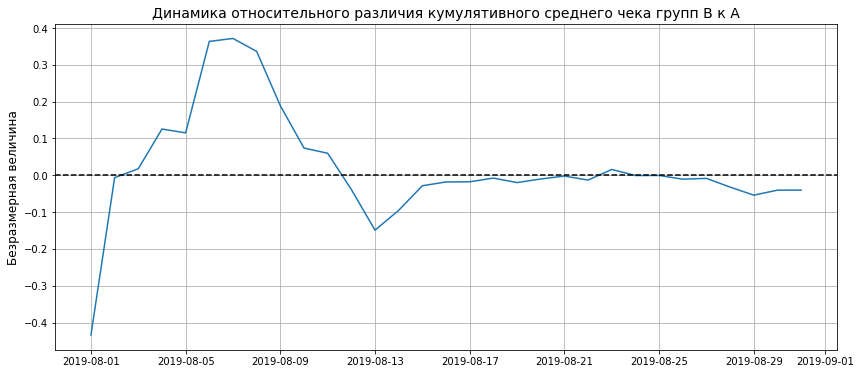

In [52]:
# перестроим график без выброса и пересекающихся пользователей

plot_camulat_mean_B(orders_clean.query("revenue != 1294500"))

<font color='orange'><b>*Наблюдение_16*</b></font>

- снова потверждается вывод предидущего графика- средний чек гр. В больше ср. чека гр. А в первой половине месяца 
- последний график опять таки более плавный и после 15 числа видно, что средний чек гр.В = среднему чеку гр.А, а к концу месяца даже стал меньше (что мы видили и до этого)
- опять видим резкие скачки в начале месяца, что снова может нас отсылать к выбросам.  

Идем дальше

### График кумулятивной конверсии по группам. 
Сделайте выводы и предположения.

In [53]:
def plot_conv(df):
    
    # создаем массив уникальных пар значений дат и групп теста
    datesGroups = df[['date','group']].drop_duplicates() 

    # получаем агрегированные кумулятивные по дням данные о заказах 
    ordersAggregated = datesGroups.apply(lambda x: df[np.logical_and(df['date'] <= x['date'], df['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

    # получаем агрегированные кумулятивные по дням данные о посетителях 
    visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], 
                                                                           visits['group'] == x['group'])] \
                                           .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
                                            .sort_values(by=['date','group'])

    # объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
    cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
    cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
    
    # считаем кумулятивную конверсию
    cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

    # отделяем данные по группе A
    cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

    # отделяем данные по группе B
    cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

    # строим графики
    
    plt.figure(figsize=(14,6))
    ax = sns.lineplot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
    ax = sns.lineplot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
    plt.legend() 
    plt.grid()
    plt.title('Сравнение динамик кумулятивной конверсии группы А и В', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_ylabel('Конверсия', fontsize=12)
    plt.show()
    
    return

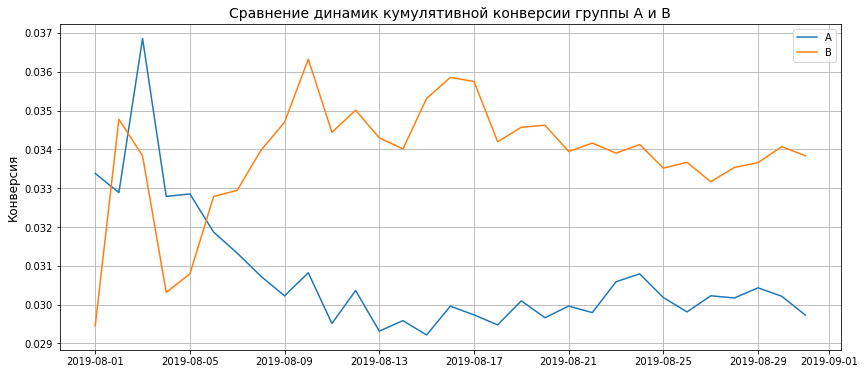

In [54]:
plot_conv(orders)

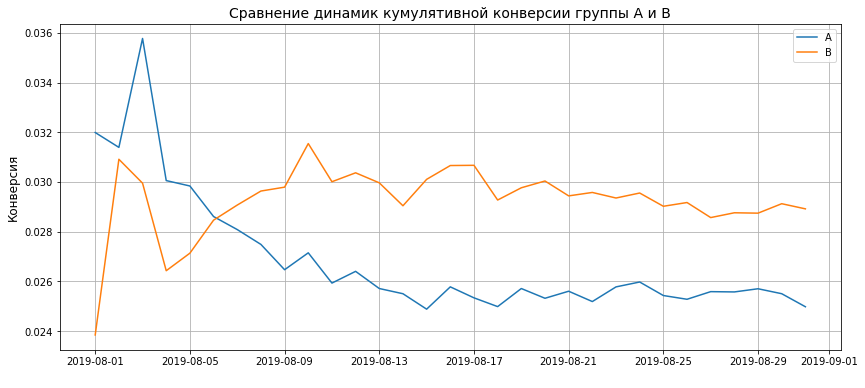

In [55]:
# перестроим график без выброса и пересекающихся пользователей

plot_conv(orders_clean.query("revenue != 1294500"))

<font color='orange'><b>*Наблюдение_17*</b></font>

- график почти симметричный, исключая начало месяца.
- конверсия в большинстве своем выше в гр. В
- в начале месяца конверсия гр.А была больше, но уже после недели, конверсия В начала расти, а гр.А просела.
- конверсия гр. В немного снижается после резкого взлета (с 05.08 до 09.08) и выходит на плато
- после двух недель можно говорить, что конверсия гр.А зафиксировалась. Тоже самое можно сказать о гр. В.
- интересные резкие скачки в начале, наверняка опять дело в аномалиях.
- на очищенном графике видно, что конверсия уменьшилась ( в среднем с 33% до 30%), но тенденция сохранилась - конверсия гр. В выше

### График относительного изменения кумулятивной конверсии группы B к группе A.
Сделайте выводы и предположения.

In [56]:
def plot_conv_cum(df):
    
    # создаем массив уникальных пар значений дат и групп теста
    datesGroups = df[['date','group']].drop_duplicates() 

    # получаем агрегированные кумулятивные по дням данные о заказах 
    ordersAggregated = datesGroups.apply(lambda x: df[np.logical_and(df['date'] <= x['date'], df['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

    # получаем агрегированные кумулятивные по дням данные о посетителях 
    visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == 
                                                                           x['group'])] \
                                           .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

    # объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
    cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
    cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
    
    # считаем кумулятивную конверсию
    cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

    # отделяем данные по группе A
    cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

    # отделяем данные по группе B
    cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

    mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                               left_on='date', right_on='date', 
                                                                               how='left', suffixes=['A', 'B'])

    # строим графики
    plt.figure(figsize=(14,6))
    plt.plot(mergedCumulativeConversions['date'], 
             mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
    plt.grid()

    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=0.1, color='grey', linestyle='--')
    
    plt.title('Динамика относительного прироста кумулятивной конверсии группы B к группе A', fontsize=14)
    plt.ylabel('Безразмерная величина', fontsize=12)
    plt.show()
    
    return

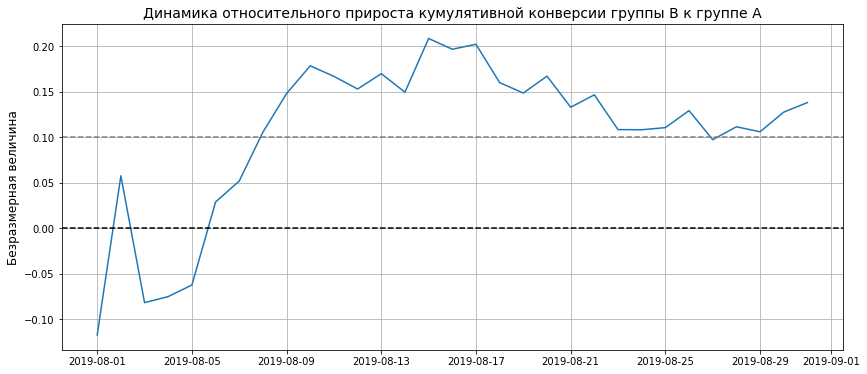

In [57]:
plot_conv_cum(orders)

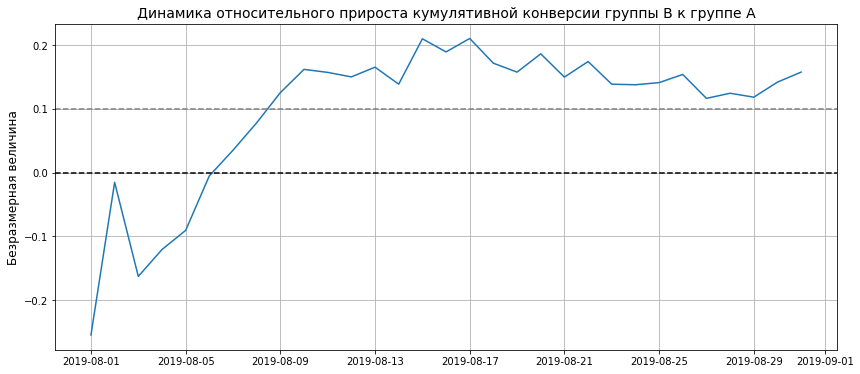

In [58]:
# перестроим график без выброса и пересекающихся пользователей

plot_conv_cum(orders_clean.query("revenue != 1294500"))

<font color='orange'><b>*Наблюдение_18*</b></font>

- опять мы видим повторение поведения предидущих графиков - конверсия гр. В после первой недели выше конверсии гр. А на 10%. 
- хотя мы видим, что со временем конверсия гр.В падает.
- на очищенном графике видим, что конверсия гр. В была меньше гр.А, дальше она стабильно больше опять таки на 10%.
- интересный скачок есть в начале, и мы наконец можем приступить к анализу аномалий

### Точечный график количества заказов по пользователям. 
Сделайте выводы и предположения.

In [59]:
def plot_hist_and_scatter_users(df):
    
    ordersByUsers = (df.groupby('user_id', as_index=False).agg({'order_id': 'nunique'}))
    ordersByUsers.columns = ['user_id', 'orders']
    
    fig = plt.figure(figsize=(16, 5))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_1 = ordersByUsers['orders'].plot(kind = 'hist', bins = 10, grid=True, rot=0)
    plt.legend()
    plt.title("Гистограмма распределения количества покупок на пользователя", fontsize=14)
    plt.xlabel("Количество покупок, шт", fontsize=12)
    plt.ylabel("Частота", fontsize=12)

    x_values = pd.Series(range(0,len(ordersByUsers)))
    ax_2 = fig.add_subplot(1, 2, 2)
    ax_2 = plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5)
    plt.title("Диаграмма рассеивания количества покупок на посетителя", fontsize=14)
    plt.xlabel("Количество покупок, шт", fontsize=12)
    plt.ylabel("Количество посетителей, чел", fontsize=12)

    plt.show()

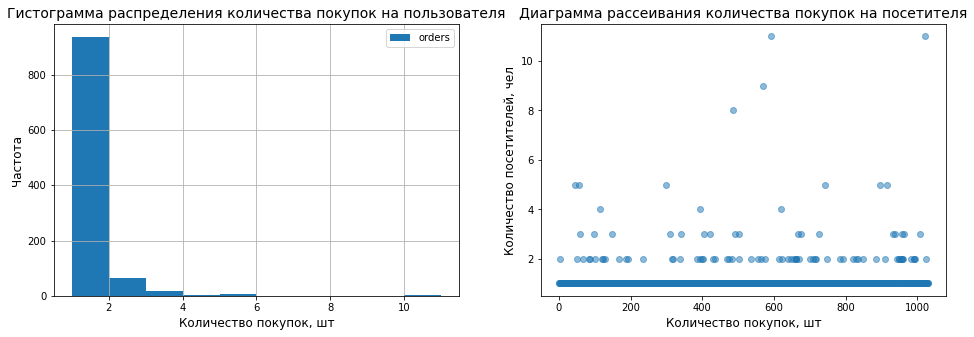

In [60]:
# сырые данные

plot_hist_and_scatter_users(orders)

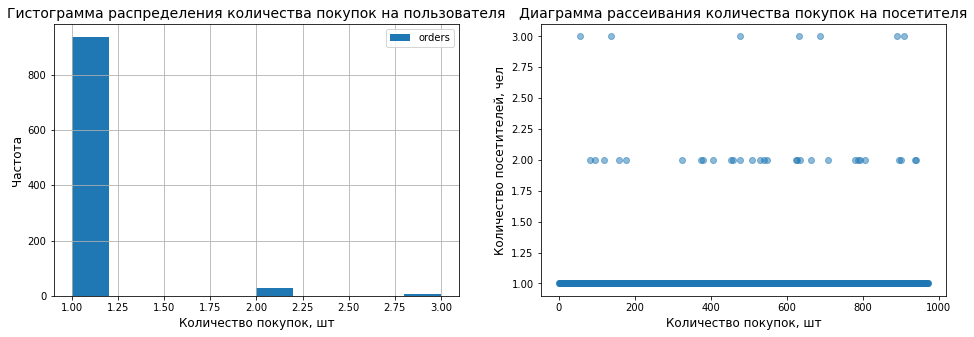

In [61]:
# данные без пересекающихся пользователей

plot_hist_and_scatter_users(orders_clean)

<font color='orange'><b>*Наблюдение_19*</b></font>

- на двух графиках видна одна и таже картина - большинство людей делают по одному заказу и все покупки больше 4-х - аномальны
- по сырым данным непонятно, 2 и 3 покупки это аномалии или нет. Для понимания, можно обратиться к описательной статистике - к процентилям (95% и 99%). 
- а вот по очищенным данным, можно сразу сказать, что 3 покупки и больше - аномальны

### Перцентили: 95-й и 99-й по количеству заказов на пользователя. 
Выберите границу для определения аномальных пользователей.

In [62]:
def percent(df):
    
    ordersByUsers = (df.groupby('user_id', as_index=False).agg({'order_id': 'nunique'}))
    ordersByUsers.columns = ['user_id', 'orders']
    
    return np.percentile(ordersByUsers['orders'], [90, 95, 99])

In [63]:
# сырые данные

percent(orders)

array([1., 2., 4.])

In [64]:
# данные без пересекающихся пользователей

percent(orders_clean)

array([1., 1., 2.])

<font color='orange'><b>*Наблюдение_20*</b></font>

- по сырым данным больше 4 покупок совершили меньше 1% пользователей и меньше 5% пользователей совершили не более 2-х покупок.
- по очищенным данным: менее 1% совершили более 2-х покупок

Значит, пределом можно считать 2 покупки.

### Точечный график стоимостей заказов. 
Сделайте выводы и предположения.

In [65]:
def plot_hist_and_scatter_reven(df, point):
       
    fig = plt.figure(figsize=(18, 15))
    ax_1 = fig.add_subplot(2, 2, 1)
    ax_1 = df['revenue'].plot(kind = 'hist', bins = 10, grid=True, rot=0)
    plt.legend()
    plt.title("Гистограмма распределения стоимости заказов на пользователя", fontsize=14)
    plt.xlabel("Стоимость заказа, млн руб", fontsize=12)
    plt.ylabel("Частота", fontsize=12)

    x_values = pd.Series(range(0,len(df['revenue'])))
    ax_2 = fig.add_subplot(2, 2, 2)
    ax_2 = plt.scatter(x_values, df['revenue'], alpha=0.5)
    plt.scatter(point, 1294500, color='red', s=50, marker='o')
    plt.title("Диаграмма рассеивания стоимости заказов на посетителя", fontsize=14)
    plt.xlabel("Колиечество покупок, шт", fontsize=12)
    plt.ylabel("Стоимость покупок, млн руб", fontsize=12)
    
    ax_1 = fig.add_subplot(2, 2, 3)
    plt.xlim(-1000, 80000)
    ax_1 = df['revenue'].plot(kind = 'hist', bins = 100, grid=True, rot=0)
    plt.legend()
    plt.title("Гистограмма распределения стоимости заказов\n на пользователя масштабированная", fontsize=14)
    plt.xlabel("Стоимость заказа, млн руб", fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    
    ax_4 = fig.add_subplot(2, 2, 4)
    plt.ylim(0, 80000)
    ax_4 = plt.scatter(x_values, df['revenue'], alpha=0.5)
    plt.title("Диаграмма рассеивания стоимости заказов\n на посетителя масшатбированная", fontsize=14)
    plt.xlabel("Колиечество покупок, шт", fontsize=12)
    plt.ylabel("Стоимость покупок, млн руб", fontsize=12)

    plt.show()

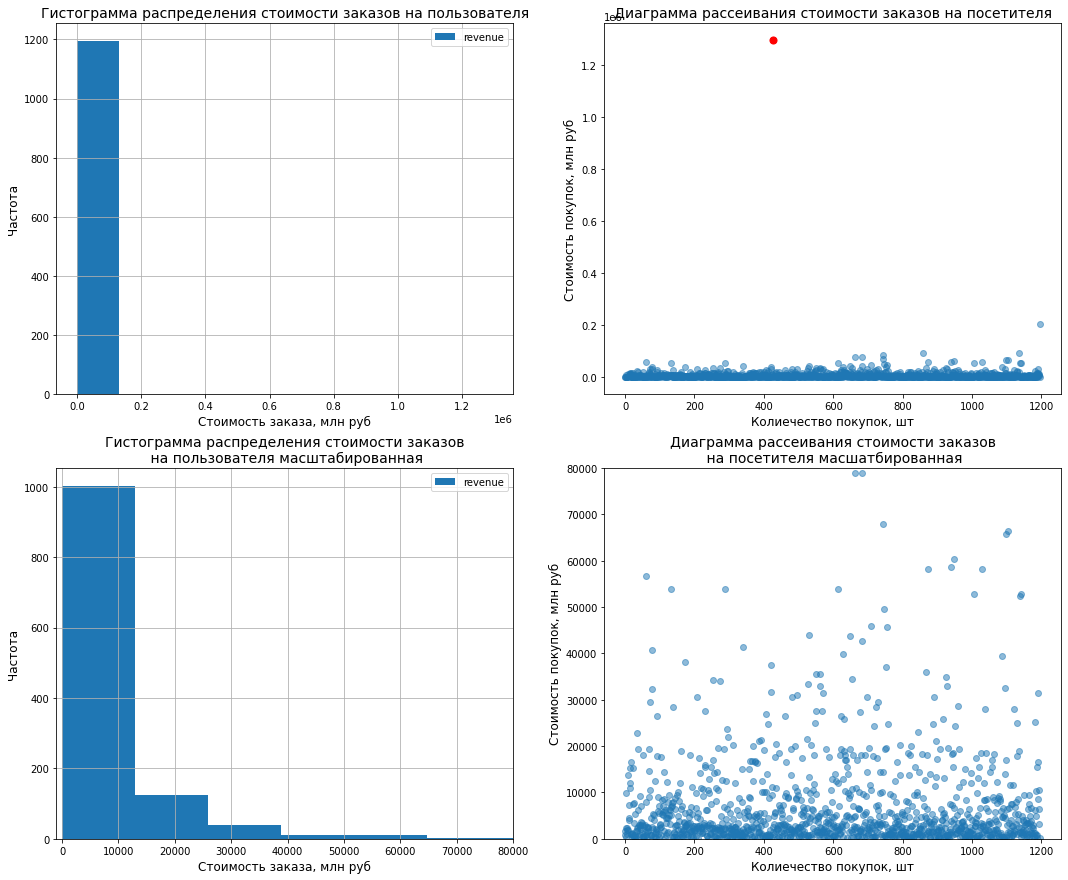

In [66]:
# сырые данные

plot_hist_and_scatter_reven(orders, 425)

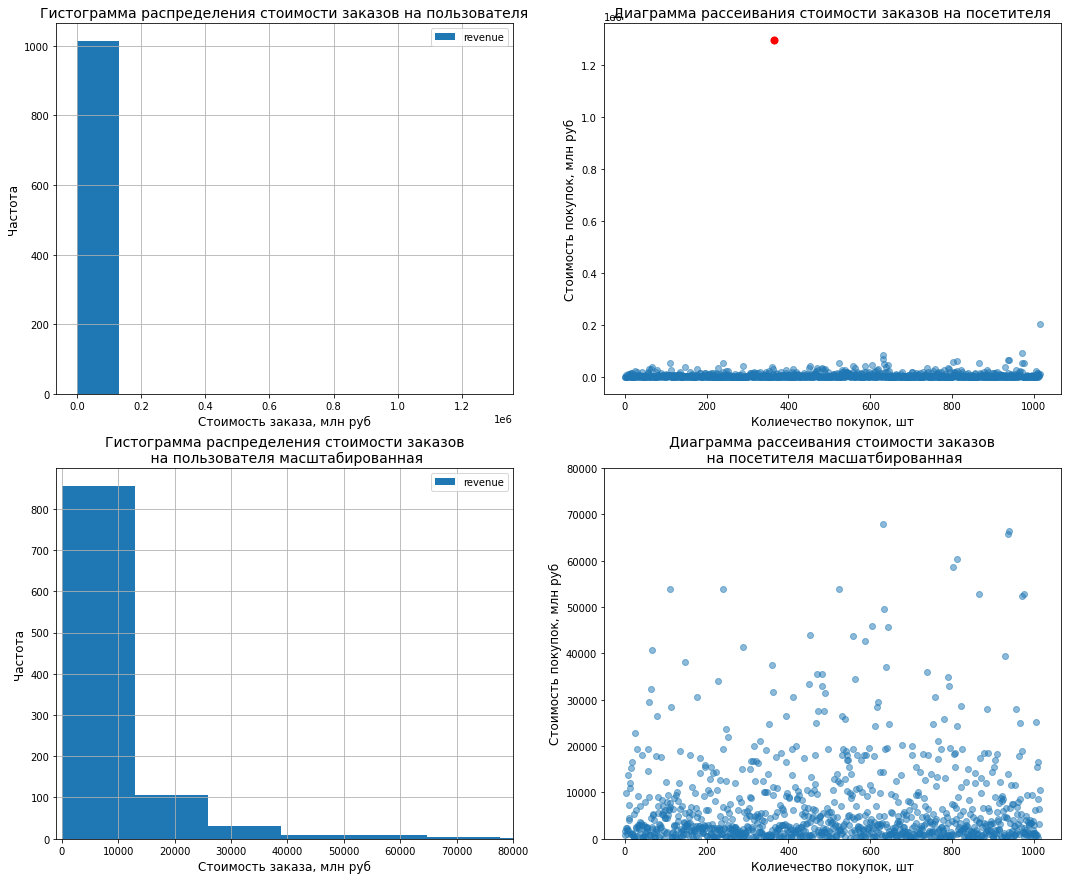

In [67]:
# данные без пересекающихся пользователей

plot_hist_and_scatter_reven(orders_clean, 365)

<font color='orange'><b>*Наблюдение_21*</b></font>

- большинство покупок по двум графикам (а надо сказать они почти одинаковые), покупки на сумму до 200 тыс.
- на масштабированных графиках видна более точная картина - много заказов сделано до 20к руб - воспользуемся перцентилями для уточнения границ
- так же мы видим нашу аномалию в 1.3 млн (красная точка)

### Перцентили: 95-й и 99-й для стоимости заказов. 
Выберите границу для определения аномальных заказов.

In [68]:
# сырые данные

np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

In [69]:
# данные без пересекающихся пользователей

np.percentile(orders_clean['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

<font color='orange'><b>*Наблюдение_22*</b></font>

- по сырым данным: 99% заказов меньше 58233 руб
- по очищенным: 99% заказов меньше 53904 руб

Так как мне кажется логичнее опираться на датасет без пересекающихся пользователей, то я возьму 54к как предел цены.

### Подготовка очищенного df

In [70]:
# подготовим новый датасет без аномалий
# выделаем user_id с аномалиями

too_many_orders = orders_clean.groupby('user_id')['order_id'].agg(['count']).reset_index()
too_many_orders = too_many_orders.query('count >= 3')

too_much_money = orders_clean.groupby('user_id')['revenue'].agg(['sum']).reset_index()
too_much_money = too_much_money.query('sum >= 54000')

In [71]:
# создаем лист с этими id

list = np.concatenate((too_many_orders['user_id'].unique(),too_much_money['user_id'].unique()), axis=0)
list = np.unique(list, axis=0)

orders_total = orders_clean.loc[~orders_clean['user_id'].isin(list)]

In [72]:
# check

if len(list) == orders_clean['user_id'].nunique() - orders_total['user_id'].nunique():
    print('ВСЕ ОК')
    print(f"Всего пользователей с аномалиями: {len(list) + bad_orders['user_id'].nunique()}")

ВСЕ ОК
Всего пользователей с аномалиями: 75


<font color='orange'><b>*Наблюдение_23*</b></font>

- мы подготовили df без пользователей, которые делали больше 2-х покупок и цена покупки превышала 54к руб

### Статистическая значимость различий в конверсии между группами по «сырым» данным. 
Сделайте выводы и предположения.

H0 - статистически значимых различий в конверсии по "сырым" данным между группами нет  
H1 - есть статистически значимые различия в конверсии по "сырым" данным между группами  
уровень значимости - 5%  
применим статистический критерий Манна-Уитни

In [73]:
def conver(df):

    visitorsADaily = visits[visits['group'] == 'A'][['date', 'visitors']]
    visitorsADaily.columns = ['date', 'visitorsPerDateA']

    visitorsACummulative = visitorsADaily.apply(
        lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateA': 'sum'}),axis=1,)
    visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


    visitorsBDaily = visits[visits['group'] == 'B'][['date', 'visitors']]
    visitorsBDaily.columns = ['date', 'visitorsPerDateB']

    visitorsBCummulative = visitorsBDaily.apply(
        lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateB': 'sum'}),axis=1,)
    visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

    ordersADaily = (
        df[df['group'] == 'A'][['date', 'order_id', 'user_id', 'revenue']]
        .groupby('date', as_index=False)
        .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'}))
    ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

    ordersACummulative = ordersADaily.apply(
        lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}),axis=1,).sort_values(by=['date'])

    ordersACummulative.columns = [
        'date',
        'ordersCummulativeA',
        'revenueCummulativeA',]

    ordersBDaily = (
        df[df['group'] == 'B'][['date', 'order_id', 'user_id', 'revenue']]
        .groupby('date', as_index=False)
        .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'}))
    ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

    ordersBCummulative = ordersBDaily.apply(
        lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),axis=1,).sort_values(by=['date'])
    ordersBCummulative.columns = [
        'date',
        'ordersCummulativeB',
        'revenueCummulativeB',]

    data = (
        ordersADaily.merge(
            ordersBDaily, left_on='date', right_on='date', how='left')
        .merge(ordersACummulative, left_on='date', right_on='date', how='left')
        .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
        .merge(visitorsADaily, left_on='date', right_on='date', how='left')
        .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
        .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
        .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))
    
    ordersByUsersA = (
    df[df['group'] == 'A']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique}))
    ordersByUsersA.columns = ['userId', 'orders']

    ordersByUsersB = (
        df[df['group'] == 'B']
        .groupby('user_id', as_index=False)
        .agg({'order_id': pd.Series.nunique}))
    ordersByUsersB.columns = ['userId', 'orders']

    sampleA = pd.concat(
        [
            ordersByUsersA['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                name='orders',),],axis=0,)

    sampleB = pd.concat(
        [
            ordersByUsersB['orders'],
            pd.Series(0,index=np.arange(
                    data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders',),],)

    print("alpha =",0.05)
    print("p-value = {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
    
    if st.mannwhitneyu(sampleA, sampleB)[1] < 0.05:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

    print("Относительное различие в конверсии между группами: {0:.3f}".format((data['ordersPerDateB'] \
                                                                               .sum()/data['visitorsPerDateB'] \
                            .sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))
    
    return

In [74]:
conver(orders)

alpha = 0.05
p-value = 0.017
Отвергаем нулевую гипотезу: между долями есть значимая разница
Относительное различие в конверсии между группами: 0.138


<font color='orange'><b>*Наблюдение_24*</b></font>

- В принципе, мы делали уже такое в п. 6.1 и еще раз можем убедиться, что в сырых данных различия между гр.А и В есть (на 5% уровне значимости). 
- Относительный выигрыш по коверсии гр. В - 13.8%

### Статистическая значимость различий в конверсии между группами по «очищенным» данным. 
Сделайте выводы и предположения.

H0 - статистически значимых различий в конверсии по очищенным данным между группами нет  
H1 - есть статистически значимые различия в конверсии по очищенным данным между группами  
уровень значимости - 5%  
применим статистический критерий Манна-Уитни

In [75]:
conver(orders_total)

alpha = 0.05
p-value = 0.006
Отвергаем нулевую гипотезу: между долями есть значимая разница
Относительное различие в конверсии между группами: 0.195


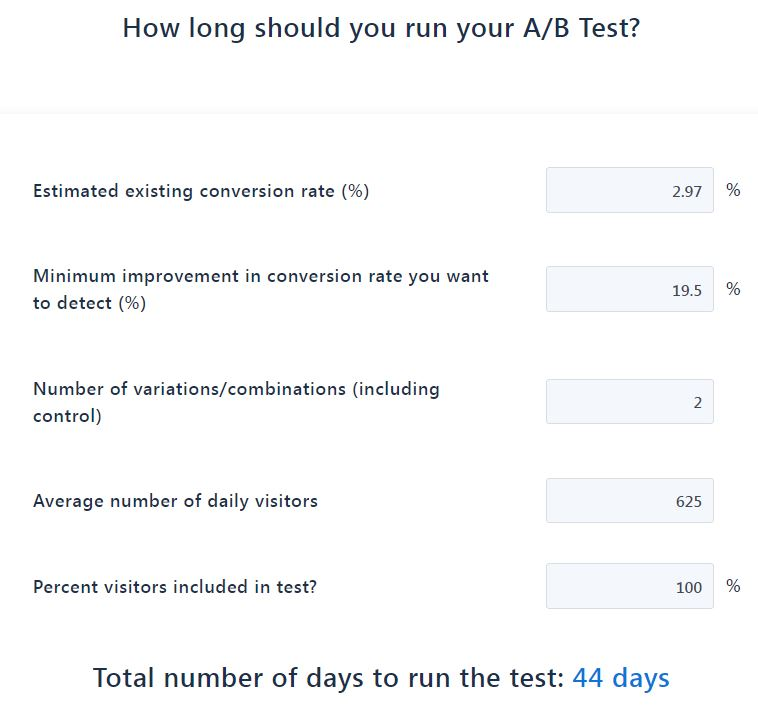

<font color='orange'><b>*Наблюдение_25*</b></font>

- Очищенные данные еще больше убеждают нас, что конверсия В выгрывает у А (теперь аж на 19.5% (вместо 13.8%)). 
- Кстати, даже при уровне значимости 1% очищенные данные не дадут принять нулевую гипотезу, что говорит о уменьшении вероятности совершить ошибку первого рода.

P.S про мой вопрос про мин количество дней на тест - я поменяла конверсию на получвшуюся, и собственно ожидаемо, количество дней сократилось. Если сделать 25%, то месяца вполне должно было хватить на тест. мб именно такой уровень и ожидали тестировщики?

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 
Сделайте выводы и предположения.

H0 - статистически значимых различий по среднему чеку "сырых" данных между группами нет  
H1 - есть статистически значимые различия по среднему чеку "сырых" данных между группами  
уровень значимости - 5%  
применим статистический критерий Манна-Уитни

In [76]:
def mean_bill(df):
    
    visitorsADaily = visits[visits['group'] == 'A'][['date', 'visitors']]
    visitorsADaily.columns = ['date', 'visitorsPerDateA']

    visitorsACummulative = visitorsADaily.apply(
        lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
            {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1,)
    visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

    visitorsBDaily = visits[visits['group'] == 'B'][['date', 'visitors']]
    visitorsBDaily.columns = ['date', 'visitorsPerDateB']

    visitorsBCummulative = visitorsBDaily.apply(
        lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
            {'date': 'max', 'visitorsPerDateB': 'sum'}),axis=1,)
    visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

    ordersADaily = (
        orders[orders['group'] == 'A'][['date', 'order_id', 'user_id', 'revenue']]
        .groupby('date', as_index=False)
        .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'})
    )
    ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

    ordersACummulative = ordersADaily.apply(
        lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}),axis=1,).sort_values(by=['date'])
    ordersACummulative.columns = [
        'date',
        'ordersCummulativeA',
        'revenueCummulativeA',]

    ordersBDaily = (
        orders[orders['group'] == 'B'][['date', 'order_id', 'user_id', 'revenue']]
        .groupby('date', as_index=False)
        .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'}))
    ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

    ordersBCummulative = ordersBDaily.apply(
        lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
            {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),axis=1,).sort_values(by=['date'])
    ordersBCummulative.columns = [
        'date',
        'ordersCummulativeB',
        'revenueCummulativeB',]

    data = (
        ordersADaily.merge(
            ordersBDaily, left_on='date', right_on='date', how='left')
        .merge(ordersACummulative, left_on='date', right_on='date', how='left')
        .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
        .merge(visitorsADaily, left_on='date', right_on='date', how='left')
        .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
        .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
        .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))
    
    print("alpha =",0.05)
    print('p-value {0:.3f}'.format(st.mannwhitneyu(df[df['group']=='A']['revenue'], 
                                                      df[df['group']=='B']['revenue'])[1]))
    
    if st.mannwhitneyu(df[df['group']=='A']['revenue'], 
                                                      df[df['group']=='B']['revenue'])[1] < 0.05:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

    print("Относительное различие средних чеков между группами: {0:.3f}". \
          format(df[df['group']=='B']['revenue'] \
                 .mean()/df[df['group']=='A']['revenue']. \
                 mean()-1))
    
    return

In [77]:
mean_bill(orders)

alpha = 0.05
p-value 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Относительное различие средних чеков между группами: 0.259


<font color='orange'><b>*Наблюдение_26*</b></font>

- Выходит, у нас нет причин отвергать, что средние чеки групп похожи ( при уровне значимости 5%).
- Но при этом средний чек гр. В больше на 26%. Это может говорить или о том, что покупателей в группе В больше или заказы дороже, чем в гр. А. А так смотрится странновато, т.к. мы говорим, что ср. чеки одинаковы, а потом бах и 26% относительного различия. возможно, дело в аномалиях.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
Сделайте выводы и предположения.

H0 - статистически значимых различий по среднему чеку очищенных данных между группами нет  
H1 - есть статистически значимые различия по среднему чеку очищенных данных между группами  
уровень значимости - 5%  
применим статистический критерий Манна-Уитни

In [78]:
mean_bill(orders_total)

alpha = 0.05
p-value 0.875
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Относительное различие средних чеков между группами: -0.012


<font color='orange'><b>*Наблюдение_27*</b></font>

- опять таки, мы не можем утверждать, что средние чеки не похожи (как и всырых данных)
- а вот средний чек гр.В теперь на ~1% ниже среднего чека гр.А (что в принципе можно частично увидеть в п. 7.3). И правда тогда, что можно грешить на аномальные значения. Даже скорее всего на одно - юзер 425, где один заказ был почти 1.3 млн руб.

### Вывод
Решение по результатам теста и объясните его. 
Варианты решений: 
1. Остановить тест, зафиксировать победу одной из групп. 
2. Остановить тест, зафиксировать отсутствие различий между группами. 
3. Продолжить тест.

На протяжении всего теста мы видели, что показатели гр.В что по сырым данным, что по очищенным, в большинстве своем дают лучший результат. Хоть средний чек даже немного меньше чем у гр.А, конверсия почти на 20% выше гр.А, что играет большую роль в оценке при таких значениях относительных различий ср. чека и конверсий. Плюс, разница конверсий стат. значима (при уровне значимости 1% по очищенным данным), из чего мы можем сделать вывод, что тест можно остановить и принять, что выбранная новая гипотеза (гр.В) сработала.